# What to Explore in the EDA Phase

This kernel will walk you through the first step in any data science project: exploring the data.

Each EDA can be different depending on the project you are working on, but you should be able to better understand your data using the measures and visualizations explained here. 

Most examples and data used in this kernel are referenced from Chapter 1 "Exploratory Data Analysis" in "Practial Statistics for Data Scientists". 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import trim_mean
import wquantiles
import statsmodels.api as sm

In [3]:
state = pd.read_csv('data/state.csv')
state.head()

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


## 1. Data Types and Missing Values

In [4]:
state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         50 non-null     object 
 1   Population    50 non-null     int64  
 2   Murder.Rate   50 non-null     float64
 3   Abbreviation  50 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ KB


## 2. Estimate of Location

### Mean

$$
\text{Mean} = \frac{\sum_{i=1}^{n} x_i}{n}
$$
$$
\text{Trimmed Mean} = \frac{\sum_{i=p+1}^{n-p} x_i}{n - 2p}
$$
$$
\text{Weighted Mean} = \frac{\sum_{i=1}^{n} w_i \cdot x_i}{\sum_{i=1}^{n} w_i}
$$

The most basic estimate of location is the __mean__. 

A variation of the mean is a __trimmed mean__, which is calculated by dropping a fixed number of sorted values at each end and then then taking an average of the remaining values. A trimmed mean eliminates the influence of extreme values. 

Another type of mean is a __weighted mean__, which is calculated by multiplying each data value, $x_i$, by a user-specified weight, $w_i$, and dividing their sum by the sum of the weights. The two main reasons for using a weighted mean are:
- Some values are __intrinsically more variable than others__, and highly variable observations are given a lower weight. For example, if we are taking the average from multiple sensors and one of the sensors is less accurate, then we might downweight the data from that sensor.
- The data collected does __not equally__ represent the different groups that we are interested in measuring. For example, because of the way an online experiment was conducted, we may not have a set of data that accurately reflects all groups in the user base. To correct that, we can gve a higher weight to the values from the groups that were underrepresented. 

### Median

$$
\text{Median} = \begin{cases}
x_{\frac{n+1}{2}} & \text{if } n \text{ is odd} \\
\frac{x_{\frac{n}{2}} + x_{\frac{n}{2}+1}}{2} & \text{if } n \text{ is even}
\end{cases}
$$

The __median__ is the middle number on a sorted list of the data. Compared to the mean, which uses __all observations__, the median depends only on the values in __the center of the sorted data__. Since __the mean is much more sensitive to the data__, there are many instances in which the median is a better metric for loction. 

For the same reasons that one uses a weighted mean, it is also possible to compute a weighted median. As with the median, we first sort the data, although each data value has an associated weight. Instead of the middle number, the weighted median is a value such that the sum of the weights is equal for the lower and upper halves of the sorted list. Like the median, the weighted median is robust to outliers. 

In [5]:
print('Location Estimates of State Population:')
print(f'mean: {state['Population'].mean()}')
print(f'trim_mean: {trim_mean(state['Population'], 0.1)}')
print(f'median: {state['Population'].median()}')

Location Estimates of State Population:
mean: 6162876.3
trim_mean: 4783697.125
median: 4436369.5


In this example, the mean is bigger than the trim mean, which is bigger than the median. 
This is because the trimmed mean excludes the largest and smallest 5 states (50 states * 0.1). 

If we want to compute the average murder rate for the country, we need to use a weighted mean or median to account for different populations in the states. 

In [6]:
print('Location Estimates of Murder Rates:')
print(f'weighted mean: {np.average(state['Murder.Rate'], weights = state['Population'])}')
print(f'weighted median: {wquantiles.median(state['Murder.Rate'], weights = state['Population'])}')

Location Estimates of Murder Rates:
weighted mean: 4.445833981123393
weighted median: 4.4


In this example, the weighted mean and the weighted median are about the same.

## 3. Estimates of Variability

Location is just one dimension in summarizing a feature. A second dimension, __variability__ (aka dispersion), measures whether the data values are tightly clustered or spread out. At the heart of statistics lies variability: measuring it, reducing it, distinguishing random from real variability, identifying the various sources of real variability, and making decisions in the presence of it. 

### Estimates Based on Deviations

$$
\text{Mean Absolute Deviation} = \frac{\sum_{i=1}^{n} |x_i - \bar{x}|}{n}
$$
$$
\text{Variance} = s^2 = \frac{\sum_{i=1}^{n} (x_i - \bar{x})^2)}{n-1}
$$
$$
\text{Standard Deviation} = s = \sqrt{\text{Variance}}
$$

The most widely used estimates of variation are based on the __deviations__, between the estimate of location and the observed data. One way to measure variability is to estimate a typical value for these deviations. A simple approach is to take __the average of the absolute values of the deviations from the mean__. The best known estimates of variability are the __variance__ and the __standard deviation__, which are based on the __squared deviations__. The standard deviation is much easier to interpret than the variance since it is __on the same scale as the original data__. The main reason the standard deviaiton is preferred in statistics over the mean absolute deviation is because, __mathematically, working with squared values is much more convenient than absolute values__. 


Neither the variance, the standard deviation, nor the mean absolute deviation is robust to outliers and extreme values. The variance and standard deviation are especially sensitive to outliers since they are based on the squared deviations. A robust estimate of variability is the __median absolute deviation from the median__.

$$
\text{Median Absolute Deviation (MAD)} = \text{Median}(|x_1 - \text{m}|, |x_2 - \text{m}|,...,|x_n - \text{m}|)
$$

### Estimates Based on Percentiles

A different approach to estimating dispersion is based on looking at __the spread of the sorted data__. The most basic measure is the __range__: the difference between the largest and smallest numbers. While the minimum and maximum values themselves are useful in identifying outliers, the range is extremely sensitive to outliers and not very useful as a general measure of dispersion in the data. To avoid the sensitivity to outliers, we can look at the range of the data after dropping values from each end. Formally, these types of estimates are based on differences between percentiles. A common measment of variability is __the difference between the 25th percentile and the 75th percentile__, called the __interquartile range__ (IQR). 

In [7]:
print('Variability Estimates of State Population:')
print(f'standard deviation: {state['Population'].std()}')
print(f'IQR: {state['Population'].quantile(0.75) - state['Population'].quantile(0.25)}')
print(f'MAD: {sm.robust.scale.mad(state['Population'])}')

Variability Estimates of State Population:
standard deviation: 6848235.347401142
IQR: 4847308.0
MAD: 3849876.1459979336


The standard deviation is almost twice as large as the MAD. This makes sense as the standard deviation is sensitive to outliers. 

We can also use the __describe()__.  It provides a summary of dispersion.

In [11]:
state.describe()

,Population,Murder.Rate
count,5.000000e+01,50.000000
mean,6.162876e+06,4.066000
std,6.848235e+06,1.915736
min,5.636260e+05,0.900000
25%,1.833004e+06,2.425000
50%,4.436370e+06,4.000000
75%,6.680312e+06,5.550000
max,3.725396e+07,10.300000


## 4. Data Distribution

It is also useful to explore how the data is distributed overall.

### Percentiles and Boxplots

Earlier, we explored how percentiles can be usedto measure the spread of the data. Percentiles are also valuable for summarizing the entire distribution. 

In [12]:
print('Percentiles of Murder Rate:')
state['Murder.Rate'].quantile([0, 0.25, 0.5, 0.75, 1])

Percentiles of Murder Rate:


0.00     0.900
0.25     2.425
0.50     4.000
0.75     5.550
1.00    10.300
Name: Murder.Rate, dtype: float64

__Boxplots__ are based on percentiles and give a quick way to visualize the distribution of data. 

Text(0, 0.5, 'Population (millions)')

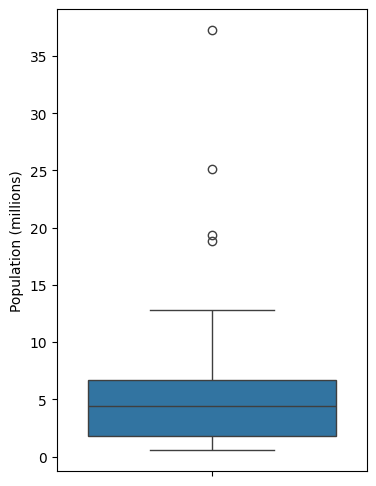

In [13]:
plt.figure(figsize=(4, 6))

sns.boxplot(data = state,
            y = state['Population'] / 1_000_000)

plt.ylabel('Population (millions)')

We can see that the median state population is about 5 million, half the states fall between about 2 million and about 7 million, and there are some high population outliers. __The top and bottom of the box are the 75th and 25th percentiles__, respectively. __The median is shown by the horizontal line in the box__. The dashed lines, referred to as whiskers, extend from the top and bottom of the box to indicate the range for the bulf of the data. Any data outside of the whiskers is plotted as single points or circles and they are often considered outliers.

### Frequency Tables and Histograms

A frequency table of a variable divides up the variable range into equally spaced segments and tells us how many values fall within each segment. 

In [14]:
binned = pd.cut(state['Population'], 10).rename('Population Group')
state_binned = pd.concat([state, binned], axis = 1)

state_binned.groupby('Population Group', observed=False).agg({
    'Population Group': 'count',  
    'Abbreviation': lambda x: ', '.join(x)  
}).rename(columns={'Population Group': 'Count'}).reset_index()

,Population Group,Count,Abbreviation
0,"(526935.67, 4232659.0]",24,"AK, AR, CT, DE, HI, ID, IA, KS, ME, MS, MT, NE..."
1,"(4232659.0, 7901692.0]",14,"AL, AZ, CO, IN, KY, LA, MD, MA, MN, MO, SC, TN..."
2,"(7901692.0, 11570725.0]",6,"GA, MI, NJ, NC, OH, VA"
3,"(11570725.0, 15239758.0]",2,"IL, PA"
4,"(15239758.0, 18908791.0]",1,FL
5,"(18908791.0, 22577824.0]",1,NY
6,"(22577824.0, 26246857.0]",1,TX
7,"(26246857.0, 29915890.0]",0,
8,"(29915890.0, 33584923.0]",0,
9,"(33584923.0, 37253956.0]",1,CA


You can also use __value_counts()__ to quickly create a frequency table.

In [15]:
binned.value_counts()

Population Group
(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: count, dtype: int64

__Histogram__ is a way to visualize a frequency table, with bins on the x-axis and the data count on the y-axis. 

Text(0.5, 0, 'Population (millions)')

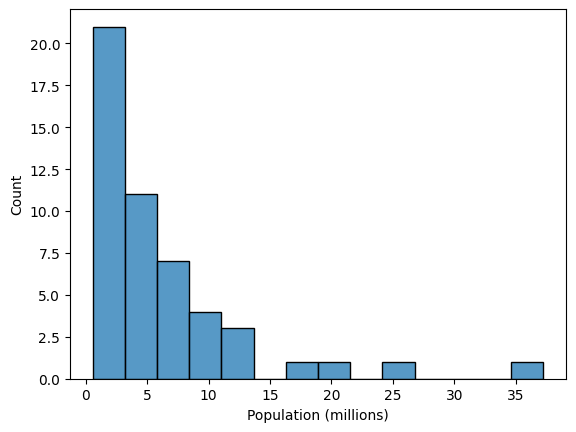

In [16]:
sns.histplot(x = state['Population'] / 1_000_000)

plt.xlabel('Population (millions)')

### Density Plots

Related to the histogram is a density plot, which shows the distribution of data values as a continuous line.

Text(0, 0.5, 'Density')

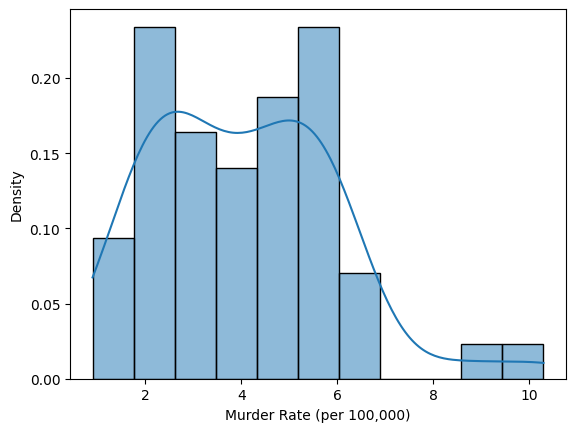

In [17]:
sns.histplot(state['Murder.Rate'], alpha=0.5, kde = True, bins = 11, stat = 'density')

plt.xlabel("Murder Rate (per 100,000)")
plt.ylabel("Density")

## 5. Categorical Data

__Bar charts__ are a common visual took for displaying a single categorical variable. Categories are listed on the x-axis, and frequencies or proportions on the y-axis. 

Text(0, 0.5, 'Count')

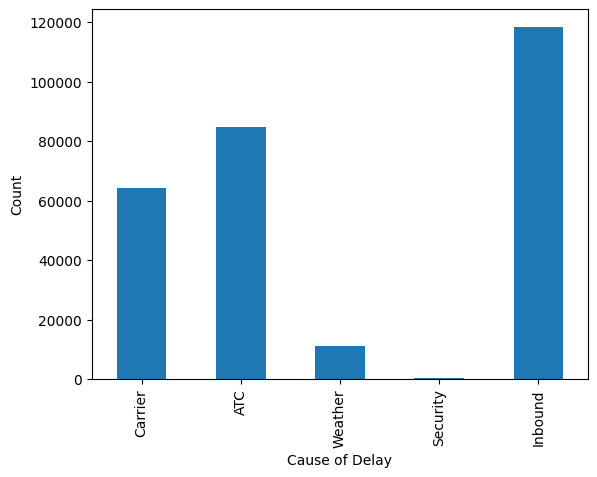

In [18]:
dfw = pd.read_csv('data/dfw_airline.csv')

dfw.T.plot.bar(legend = False)

plt.xlabel('Cause of Delay')
plt.ylabel('Count')

A bar chart resembles a histogram; in a bar chart the x-axis represents different categories of a factor variable, while in a histogram the x-axis represents values of a single variable on a numeric scale. In a histogram, the bars are typically shown touching each other, with gaps indicating values that did not occur in the data. In a bar chart, the bars are shown separate from one another.


### Mode

The __mode__ is the value that appears most often in the data. For example, using the "Cause of Delay at DFW" example above, the mode of the cause of delay is "Inbound".


### Expected Value

A special type of categorical data is data in which the categories represent or can be mapped to discrete values on the same scale. For example, a cloud techonology company offers two levels of service, one priced at \\$300 and another at \\$50 per month. The company offers free webinars for more leads, and it figures that 5% of the attendees will sign up for the \\$300 service, 15% will sign up for \\$50 service, and 80% will not sign up for anything. This data can be summed up for financial purposes in a single "__expected value__", which is a form of weighted mean, in which the weights are probabilities. 

The expected value is calculated as follows:
- Multiply each outcome by its probability of occurrence.
- Sum these values

In the cloud service example, the expected value of a webinar attendee is \\$22.5 per month, calculated as follows: <br>
EV = (0.05)(300) + (0.15)(50) + (0.80)(0) = 22.5

## 6. Correlation

EDA in many projects involvs examining correlation among predictors, and between predictors and a target variable. __Correlation coefficient__ gives an estimate of the correlation between two variables. 

$$
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y}))}{(n-1)s_xs_y}
$$

The correlation coefficient always lies between +1 and -1; 0 indicates no correlation. Variables can have an association that is not linear, in which case the correlatino coefficient may not be a useful metric. Also, like the mean and standard deviation, the correlation coefficient is sensitive to outliers in the data. 

<Axes: >

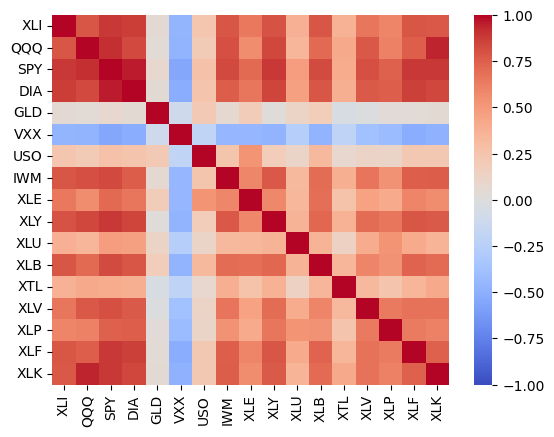

In [19]:
sp500_sym = pd.read_csv('data/sp500_sectors.csv')
sp500_px = pd.read_csv('data/sp500_data.csv.gz', index_col=0)

etfs = sp500_px.loc[sp500_px.index > '2012-07-01',
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]

sns.heatmap(etfs.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm')

### Scatterplot

The standard way to visualize the relatinoship between two measured data variables is with a scatterplot. 

Text(0, 0.5, 'Verizon')

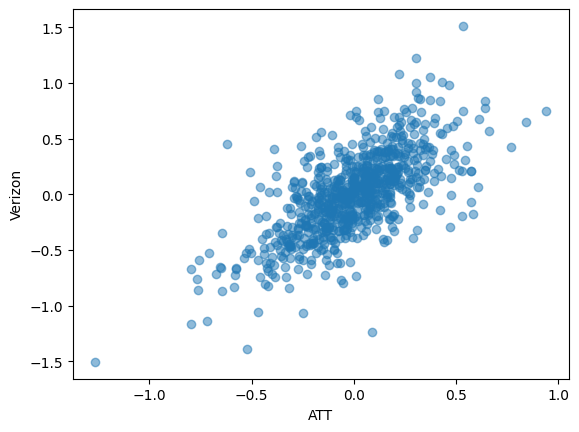

In [20]:
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]

plt.scatter(data = telecom, x = 'T', y = 'VZ', alpha = 0.5)

plt.xlabel('ATT')
plt.ylabel('Verizon')

## 7. Two or More Variables

Familiar estimators like mean and variance look at variables one at a time (univariate analysis). Correlation analysis is an important method that compares two variables (bivariate analysis). We can also look at additional estimates and plots, and at more tahn two variables (multivariate analysis).

### Hexagonal Binning Plot (Numeric vs Numeric)

Scatterplots are fine when there is a relatively small number of data values, but for data sets with hundreds of thousands or millions of records, a scatterplot wll be too dense, so we need a different way to visualize the relationship. A hexagonal binning groups the records into hexagonal bins and plots the fexagons with a color indicating the number of record in that bin.  

Text(0, 0.5, 'Tax-Assessed Value')

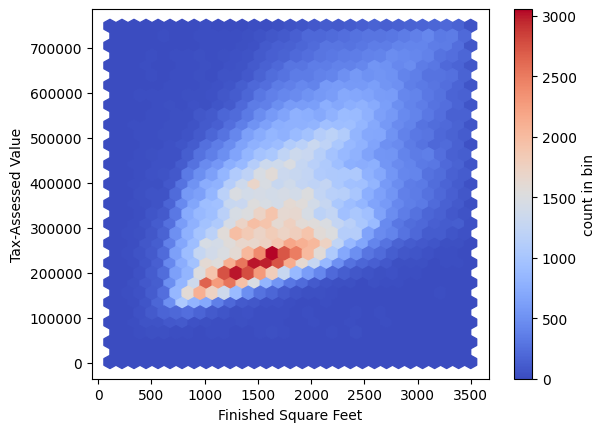

In [21]:
kc_tax = pd.read_csv('data/kc_tax.csv.gz')
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) & 
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]

plt.hexbin(x = kc_tax0['SqFtTotLiving'], 
           y = kc_tax0['TaxAssessedValue'], 
           gridsize=30,
           cmap = 'coolwarm')  

plt.colorbar(label='count in bin')
plt.xlabel('Finished Square Feet')
plt.ylabel('Tax-Assessed Value')


## Contours Plot (Numeric vs Numeric)

A Contours plot uses contours overlaid onto a scatterplot to visualize the relationship between two numeric variables. The contours are essentially a topographical map to two variables; each contour band represents a specific density of points, increasing as one nears a "peak". 

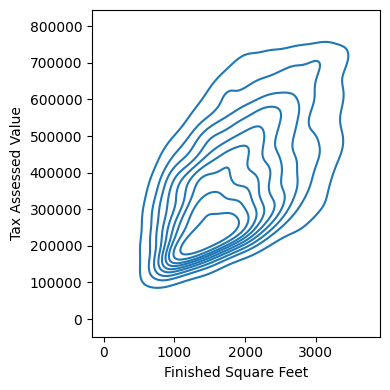

In [83]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.kdeplot(data=kc_tax0.sample(10000), x='SqFtTotLiving', y='TaxAssessedValue', ax=ax)

ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value')

## Contingency Table (Two Categorical Variables)

A useful way to summarize two categorical variables is a contingency table - a table of counts by category. Pivot tables in Excel are perhaps the most common tool used to create contingency tables. 

In [22]:
lc_loans = pd.read_csv('data/lc_loans.csv')

lc_loans.pivot_table(index='grade', 
                     columns='status', 
                     aggfunc=lambda x: len(x), 
                     margins=True)

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,1562,50051,20408,469,72490
B,5302,93852,31160,2056,132370
C,6023,88928,23147,2777,120875
D,5007,53281,13681,2308,74277
E,2842,24639,5949,1374,34804
F,1526,8444,2328,606,12904
G,409,1990,643,199,3241
All,22671,321185,97316,9789,450961


### Boxplot (Categorical and Numeric Data)

Boxplots are a simple way to visually compare the distributions of a numeric variable grouped according to a categorical variable.

<Axes: xlabel='airline', ylabel='pct_carrier_delay'>

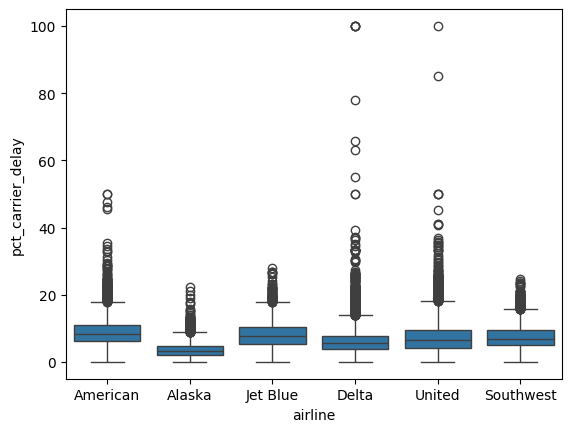

In [25]:
airline_stats = pd.read_csv('data/airline_stats.csv')

sns.boxplot(data = airline_stats,
            x = 'airline',
            y = 'pct_carrier_delay')

### Violin Plot (Categorical and Numeric Data)

A violin plot is an enhancement to the boxplot and plots the density estimate. The advantage of a violin plot is that it can show nuances in the distribution that aren't perceptible in a boxplot. On the other hand, the boxplot more clearly shows the outliers in the data.

<Axes: xlabel='airline', ylabel='pct_carrier_delay'>

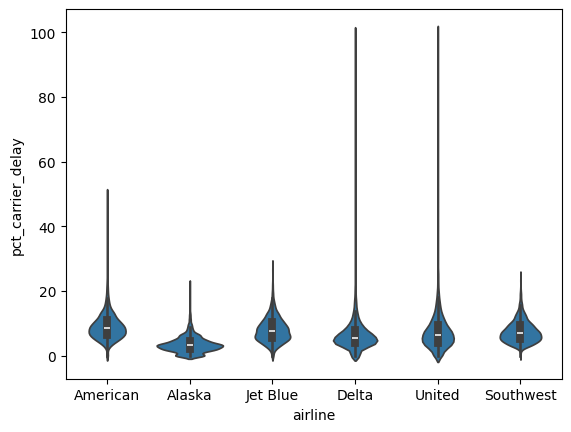

In [26]:
sns.violinplot(data = airline_stats,
            x = 'airline',
            y = 'pct_carrier_delay')

### Visualize Multiple Variables

The types of charts used to compare two variables are readily extended to more variables through the notion of coditioning. As an example, our housing example showed the relationship between homes' finished square feet and their tax-assessed values. We observed that there appears to be a cluster of homes that have higher tax-assessed value per square foot. Diving deeper, we can plot the data for a set of zip codes to see the effect of location. Now the picture is much clearer: tax-assessed value is much higher in some zip codes than in others. 

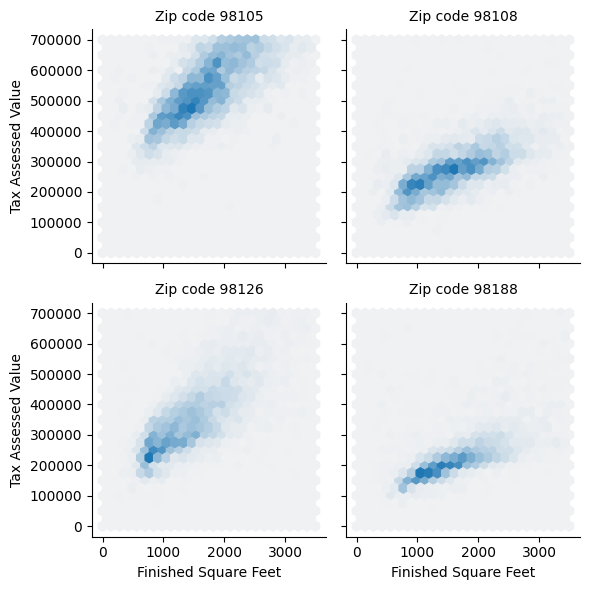

In [28]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

## Summary

The key idea of EDA is that the first and most important step in any project based on data is to look at the data. By summarizing and visualizing the data, you can gain valuable intuition and understanding of the project. 